In [45]:
from graphviz import Digraph
import math

In [46]:
class value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    

In [47]:
def trace(root):
    nodes, edges = set(), set()
    def build(v): 
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            op_uid = uid + n._op
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2, in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    dot.render('output_graph', format='svg', view=True)
    return dot

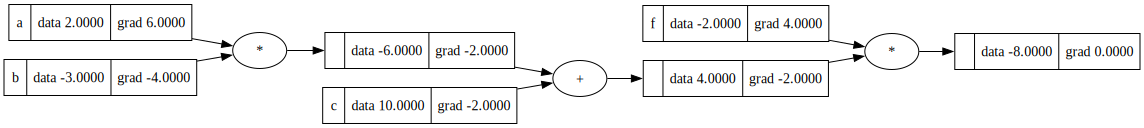

In [48]:
draw_dot(l)

In [49]:
def lol():
    h = 0.0001
    
    a = value(2.0, label='a')
    b = value(-3.0, label='b')
    c = value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = value(-2.0, label='f')
    l = d * f; l.label = 'l'
    l1 = l.data

    a = value(2.0, label='a')
    b = value(-3.0, label='b')
    c = value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = value(-2.0, label='f')
    l = d * f; l.label = 'l'
    l2 = l.data

    print((l2 - l1)/h)


lol()
        

0.0


In [50]:
#inputs x1, x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1, w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the nerouns
b = value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
o.label = 'o'



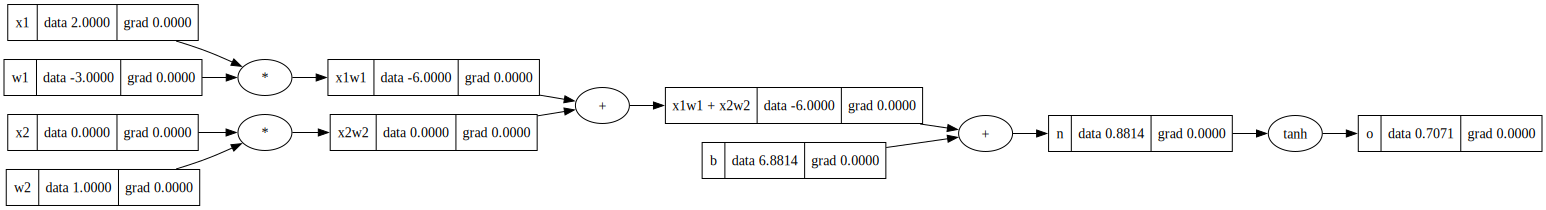

In [51]:
draw_dot(o)

In [52]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad 
x2.grad = w2.data * x2w2.grad 
x1w1.grad = 0.5
x2w2.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
n.grad = 0.5
o.grad = 1.0
1 - o.data**2

0.4999999999999999

In [53]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]